In [3]:
# from datasets import load_dataset
import pandas as pd
import numpy as np
import os
import re
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
processed_afrisenti = pd.read_csv('/kaggle/input/preprocessed-ary-afrisenti/full_processed_tweets_labels.csv')
processed_collected_data = pd.read_csv('/kaggle/input/reviews-dataset-processed/processed_collected_data.csv')

In [5]:
processed_afrisenti.rename(columns={'processed_tweet':'review'}, inplace=True)
processed_collected_data.rename(columns={'processed_review':'review'}, inplace=True)

In [6]:
full_data = pd.concat([processed_afrisenti, processed_collected_data], ignore_index=True)

In [7]:
full_data = full_data.convert_dtypes()
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9992 entries, 0 to 9991
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   9992 non-null   string
 1   review  9991 non-null   string
dtypes: string(2)
memory usage: 156.2 KB


In [8]:
full_data.dropna(subset=['review'], inplace=True)

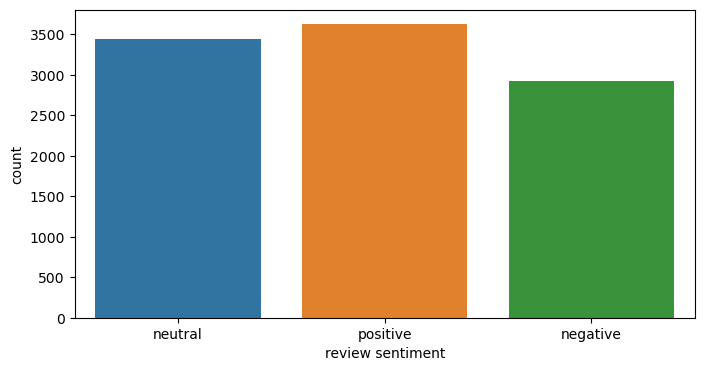

In [9]:
plt.figure(figsize=(8, 4))
sns.countplot(x="label", data=full_data)
plt.xlabel('review sentiment')
plt.show()

In [10]:
label_map = {'positive': 0, 'negative': 1, 'neutral': 2}
full_data.label = full_data.label.map(label_map)

In [13]:
from transformers import AutoTokenizer, AutoModel
from transformers import DataCollatorWithPadding
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
from torch.optim import AdamW
from transformers import BertModel
from transformers import get_linear_schedule_with_warmup
import random
import time
import torch.nn.functional as F

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [16]:
def set_seed(seed_value=42):
    """
    Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [18]:
RANDOM_SEED = 42
set_seed(RANDOM_SEED)    # Set seed for reproducibility

In [19]:
df_train, df_test = train_test_split(full_data, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [20]:
X_train = df_train.review.to_list()
Y_train = df_train.label.to_list()

In [21]:
X_dev = df_val.review.to_list()
Y_dev = df_val.label.to_list()

In [22]:
X_test = df_test.review.to_list()
Y_test = df_test.label.to_list()

In [23]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("SI2M-Lab/DarijaBERT-mix")

In [24]:
model = AutoModel.from_pretrained("SI2M-Lab/DarijaBERT-mix")

In [25]:
def preprocessing_for_bert(data, max_len):

    encoded_sent = tokenizer.batch_encode_plus(
                batch_text_or_text_pairs=data,  # Preprocess sentence
                add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
                max_length=max_len,             # Max length to truncate/pad
                padding='max_length',           # Pad sentence to max length
                truncation=True,
                return_tensors='pt',            # Return PyTorch tensor
                return_attention_mask=True      # Return attention mask
    )
    
    return encoded_sent.get('input_ids'), encoded_sent.get('attention_mask')

In [26]:
def create_data_loader(reviews, targets, tokenizer, max_len, batch_size):
    
    input_ids, masks = preprocessing_for_bert(reviews, max_len)
    labels = torch.tensor(targets)
    dataset = TensorDataset(input_ids, masks, labels)
    sampler = RandomSampler(dataset)
    dataloader = DataLoader(dataset, sampler=sampler, batch_size=batch_size)
    
    return dataloader

In [27]:
MAX_LEN = 128
batch_size = 64

train_dataloader = create_data_loader(X_train, Y_train, tokenizer, MAX_LEN, batch_size)
val_dataloader = create_data_loader(X_dev, Y_dev, tokenizer, MAX_LEN, batch_size)
test_dataloader = create_data_loader(X_test, Y_test, tokenizer, MAX_LEN, batch_size)

In [64]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class SentiDarija(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    freeze_bert (bool): Set `False` to fine-tune the DarijaBERT model
        """
        super(SentiDarija, self).__init__()
        # Specify hidden size of DarijaBERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 64, 3

        # DarijaBERT
        self.bert = model

        # Instantiate an 2-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(H, D_out)
        )
        
        # Freeze DarijaBERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to DarijaBERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 45 µs, sys: 6 µs, total: 51 µs
Wall time: 54.8 µs


In [68]:
def initialize_model(epochs=4, lr=5e-5):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    SentiDarija_classifier = SentiDarija(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    SentiDarija_classifier.to(device)

    # Create the optimizer
    optimizer = torch.optim.AdamW(SentiDarija_classifier.parameters(),
                                  lr=lr,    # learning rate
                                  eps=1e-8    # epsilon value
                                  )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return SentiDarija_classifier, optimizer, scheduler

In [69]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """
    Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            
            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [70]:
EPOCHS = 4
SentiDarija_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS, lr=5e-5)

In [72]:
train(SentiDarija_classifier, train_dataloader, val_dataloader, epochs=EPOCHS, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.029648   |     -      |     -     |   16.77  
   1    |   40    |   0.824091   |     -      |     -     |   14.52  
   1    |   60    |   0.708624   |     -      |     -     |   14.62  
   1    |   80    |   0.637495   |     -      |     -     |   14.78  
   1    |   100   |   0.628122   |     -      |     -     |   14.71  
   1    |   120   |   0.634640   |     -      |     -     |   14.64  
   1    |   124   |   0.634676   |     -      |     -     |   2.83   
----------------------------------------------------------------------
   1    |    -    |   0.742566   |  0.536785  |   76.39   |   96.68  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------------

In [96]:
import gc

SentiDarija_classifier.cpu()

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(160000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [97]:
gc.collect()
torch.cuda.empty_cache()

In [208]:
torch.cuda.empty_cache()

In [75]:
torch.save({'epoch': 4,
            'model_state_dict': SentiDarija_classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
            }, 'model.pt')

In [ ]:
checkpoints = torch.load('/kaggle/working/model.pt')

In [ ]:
loaded_model = SentiDarija()
optimizer = AdamW()

loaded_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [111]:
sents = ["tayjini zwin nit tay3jebni"]

encoded = tokenizer(sents[0], padding=True, pad_to_multiple_of=64, return_tensors='pt')

In [114]:
encoded.to('cuda')

{'input_ids': tensor([[     2, 129022,   3523,   9013,  74488,  19451,      3,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0,

In [115]:
with torch.no_grad():
    logits = SentiDarija_classifier(encoded['input_ids'], encoded['attention_mask'])

In [116]:
logits

tensor([[ 4.1237, -2.5116, -1.5960]], device='cuda:0')

In [122]:
code_to_class = {v:k for k,v in label_map.items()}

In [123]:
pred = torch.argmax(logits, dim=1).flatten()
code_to_class[pred.item()]

'positive'

In [88]:
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained DarijaBERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [100]:
_, test_acc = evaluate(SentiDarija_classifier, test_dataloader)

In [101]:
print('Test accuracy:', test_acc)

Test accuracy: 79.375


In [91]:
# Compute predicted probabilities on the test set
test_probs = bert_predict(SentiDarija_classifier, test_dataloader)

In [95]:
test_probs.shape

(1000, 3)

In [96]:
test_probs[:5]

array([[0.99552274, 0.00123579, 0.00324148],
       [0.00303892, 0.00188837, 0.99507266],
       [0.02043795, 0.9757587 , 0.00380336],
       [0.01678038, 0.97599596, 0.00722363],
       [0.00484868, 0.00773396, 0.98741734]], dtype=float32)